# Neurosynth Analysis

## Import packages & data

In [1]:
#basic
import os
import glob
import pandas as pd
import numpy as np

#for term map correlations
# Core functionality for managing and accessing data
from neurosynth import Dataset
# Analysis tools for meta-analysis, image decoding, and coactivation analysis
from neurosynth import meta, decode, network

#for topic map correlations
from numpy import corrcoef, nan_to_num, ma
import nibabel as nib

#for regression & resampling
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random # to perform reproducible randomization
from scipy import stats #for z-scoring model before running

#topics
topics = glob.glob('neurosynth_topics/v5-topic-200-maps/*.nii.gz')
topics.sort()

#unthresholded z-stat maps
sc = 'juror_z-stat_maps/juror_scenario.nii.gz'
ev = 'juror_z-stat_maps/juror_evidence.nii.gz'
cs = 'juror_z-stat_maps/juror_case_strength.nii.gz'
pun = 'juror_z-stat_maps/juror_punishment.nii.gz'

#whole brain mask
brainmask = 'mask/whole_brain_mask.nii.gz'

## Run Term Map Correlations

runs Neurosynth Decoder for 3,168 term reverse inference maps and 200 topic reverse inference maps from the Neurosynth Database. Term decoding/correlations are estimated using the Neurosynth package. Topic correlations are estimated using tools in nibabel.

### Build database

In [ ]:
# Comment in/out only as needed since only need to run once
# Create a new Dataset instance
#dataset = Dataset('neurosynth_terms/database.txt')

# Add some features
#dataset.add_features('neurosynth_terms/features.txt')
#dataset.save('neurosynth_terms/dataset.pkl')
#dataset = Dataset.load('neurosynth_terms/dataset.pkl')   # Note the capital D in the second Dataset--load() is a class method

### Run decoder/correlation analysis

In [ ]:
# Comment in/out only as needed since only need to run once and very time/processing intensive...
# Decode images
#decoder = decode.Decoder(dataset)
#data = decoder.decode(['juror_z-stat_maps/juror_scenario.nii.gz',
#                       'juror_z-stat_maps/juror_evidence.nii.gz',
#                       'juror_z-stat_maps/juror_case_strength.nii.gz',
#                       'juror_z-stat_maps/juror_punishment.nii.gz'],
#                      save='decoding_output/decoding_results_terms_unthresholded.csv')

## Run Topic Map Correlations

In [4]:
#mask
mask_img = nib.load(brainmask)
mask_data = mask_img.get_fdata()
mask_n_voxels = np.prod(mask_data.shape[:-1])
mask_data_2d = np.reshape(mask_data, (mask_n_voxels, mask_data.shape[-1]))

#transform the unthresholded z-stat maps - scenario
sc_img = nib.load(sc)
sc_data = sc_img.get_fdata()
sc_n_voxels = np.prod(sc_data.shape[:-1])
sc_data_2d = np.reshape(sc_data, (sc_n_voxels, sc_data.shape[-1]))
sc_masked = sc_data_2d*mask_data_2d
sc_masked2 = ma.masked_where(mask_data_2d==0, sc_data_2d)

#transform the unthresholded z-stat maps - evidence
ev_img = nib.load(ev)
ev_data = ev_img.get_fdata()
ev_n_voxels = np.prod(ev_data.shape[:-1])
ev_data_2d = np.reshape(ev_data, (ev_n_voxels, ev_data.shape[-1]))
ev_masked = ev_data_2d*mask_data_2d
ev_masked2 = ma.masked_where(mask_data_2d==0, ev_data_2d)

#transform the unthresholded z-stat maps - case strength
cs_img = nib.load(cs)
cs_data = cs_img.get_fdata()
cs_n_voxels = np.prod(cs_data.shape[:-1])
cs_data_2d = np.reshape(cs_data, (cs_n_voxels, cs_data.shape[-1]))
cs_masked = cs_data_2d*mask_data_2d
cs_masked2 = ma.masked_where(mask_data_2d==0, cs_data_2d)

#transform the unthresholded z-stat maps - punishment
pun_img = nib.load(pun)
pun_data = pun_img.get_fdata()
pun_n_voxels = np.prod(pun_data.shape[:-1])
pun_data_2d = np.reshape(pun_data, (pun_n_voxels, pun_data.shape[-1]))
pun_masked = pun_data_2d*mask_data_2d
pun_masked2 = ma.masked_where(mask_data_2d==0, pun_data_2d)

#empty dicts to hold correlation values + topic names & numbers
t_correl_sc_dat = []
t_correl_ev_dat = []
t_correl_cs_dat = []
t_correl_pun_dat = []
t_num = []
t_name = []
for t in topics:
    t_name_split = t.split('/')
    t_name_file = t_name_split[2]
    t_name_topic = t_name_file.split('_')
   #get topic numbers
    t_name_topic_num = t_name_topic[1]
    t_name_topic_num = str(t_name_topic_num).zfill(3)
    t_num.append(t_name_topic_num)
   #get topic names
    names = [t_name_topic[2], t_name_topic[3], t_name_topic[4]]
    t_name_topic_name = list(map("".join, names)) 
    t_name.append(t_name_topic_name)
   #process the images
    img = nib.load(t)
    data = img.get_fdata()
    n_voxels = np.prod(data.shape[:-1])
    data_2d = np.reshape(data, (n_voxels, data.shape[-1]))
    #mask the topic map with a whole brain mask
    data_masked = data_2d*mask_data_2d
    data_masked2 = ma.masked_where(mask_data_2d==0, data_2d)
    
    #flatten into a 1-D array & run correlation
    #correlation for scenario map
    t_correl_sc = ma.corrcoef(sc_masked2.flatten(),data_masked2.flatten())[0,1]
    t_correl_sc_dat.append(t_correl_sc)
    
    #correlation for evidence accumulation map
    t_correl_ev = ma.corrcoef(ev_masked2.flatten(),data_masked2.flatten())[0,1]
    t_correl_ev_dat.append(t_correl_ev)
    
    #correlation for case strength rating map
    t_correl_cs = ma.corrcoef(cs_masked2.flatten(),data_masked2.flatten())[0,1]
    t_correl_cs_dat.append(t_correl_cs)
    
    #correlation for punishment rating map
    t_correl_pun = ma.corrcoef(pun_masked2.flatten(),data_masked2.flatten())[0,1]
    t_correl_pun_dat.append(t_correl_pun)

#merge the correlations into a single dataframe
topic_correlations = pd.DataFrame(list(zip(t_num, t_name,
                                           t_correl_sc_dat, t_correl_ev_dat,
                                           t_correl_cs_dat, t_correl_pun_dat)),
                                  columns=['topic_num', 'topic_name',
                                           'scenario','evidence',
                                           'case_strength','punishment'])
#save the correlations to a csv
topic_correlations.to_csv('decoding_output/decoding_results_topics_unthresholded.csv')


## Decision Making Models for Multiple Linear Regression

```
Models
└───Extra-evidentiary
│   │
│   └───Moral Judgment
│   |    │  
|   |    └───Moral
│   |    │  
|   |    └───Social
│   │
|   └───Affect
│   
└───Evidentiary
    │
    └───Utility
    |    │  
    |    └───Probability
    |    │  
    |    └───Value
    │
    └───Narrative
         │  
         └───Experience, Culture, and Recall
         |     │
         |     └───Culture & Ideation Bias
         |     │
         |     └───Recall
         │  
         └───Reading
         │  
         └───Working Memory


```

## Primary Models


##  Model 1: Utility
- Topic 002: problem, problems, arithmetic, solving, calculation, mental, mathematical, math, ag, addition, angular, multiplication, parietal, subtraction, operations, retrieval, operation, number, solution, gyrus, ef, solved, sulcus, numerical, insight, solutions, intraparietal, competence, solve, single, strategies, adults, cognitive, cognition, mathematics, arithmetical, small, simple, digit, size


- Topic 010: ofc, orbitofrontal, cortex, lateral, medial, amygdala, mofc, frontal, evaluation, frontopolar, pole, prefrontal, limbic, systems, orbital, regional, lofc, paralimbic, reward, negative, specifically, orbito, serving, associations, plays, values, functioning, immediately, unfavorable, sectors, social, successful, olfactocentric, vigilant, favorable, sections, declared, reconfiguration, temporopolar, bmrmi


- Topic 086: ips, number, numerical, intraparietal, numbers, magnitude, sulcus, symbolic, parietal, distance, dd, representation, numerosity, digit, small, digits, size, large, arabic, estimation, quantifiers, nonsymbolic, magnitudes, quantity, counting, larger, arrays, quantities, abstract, symbols, line, letters, dyscalculia, congruity, sulci, dots, notation, fractions, numerals, adults


- Topic 128: prediction, error, outcome, errors, predictive, probability, expectation, predictions, outcomes, events, expectations, uncertainty, predictability, unexpected, predicted, predict, model, environment, unpredictable, models, predictable, expectancy, entropy, reflected, future, cancer, chemotherapy, predicting, likelihood, adjustment, probabilities, pe, updating, prior, coding, adaptation, upcoming, omission, theories, environmental	


- Topic 186: decision, making, choice, decisions, choices, uncertainty, outcomes, discounting, outcome, striatum, rewards, options, valuation, preferences, make, values, preference, probability, reward, subjective, individual, gains, economic, losses, loss, option, process, choose, aversion, gambling, insula, reputation, risky, selection, intertemporal, accumulation, people, prior, igt, choosing


- Topic 197: reward, striatum, anticipation, ventral, monetary, rewards, motivation, loss, response, incentive, striatal, motivational, sensitivity, punishment, gain, outcomes, outcome, rewarding, money, delay, magnitude, mesolimbic, losses, gains, anticipatory, midbrain, salience, receipt, aversive, gambling, motivated, appetitive, rewarded, cues, feedback, incentives, dopaminergic, win, anticipated, avoidance


##  Model 2: Affect
- Topic 126: anxiety, aggression, anxious, trait, amygdala, cr, disorder, gad, anticipation, emotional, anticipatory, high, aggressive, ha, social, worry, fear, temperament, individuals, panic, scores, anger, threat, symptoms, phobia, reactivity, dental, relationship, limbic, iu, provocation, reactive, generalized, characterized, subclinical, bi, regulation, insula, somatic, paradigm


- Topic 139: faces, emotional, facial, expressions, emotion, amygdala, neutral, fearful, happy, face, sad, emotions, angry, expression, social, fear, response, perception, affective, recognition, anger, affect, disgust, viewing, happiness, gender, sadness, magnetic, fusiform, presented, resonance, interaction, emotionally, salient, expressing, masked, threat, limbic, viewed, sensitivity


- Topic 180: amygdala, threat, fear, anxiety, response, avoidance, reactivity, threatening, habituation, responding, shock, aversive, heightened, emotional, cues, approach, affective, amygdalar, threats, bnst, research, bla, individuals, emotion, basolateral, hippocampus, danger, periaqueductal, limbic, nucleus, amygdalae, implicated, defensive, stress, insula, trait, exaggerated, safe, anxious, startle


##  Model 3: Moral Judgement
- Topic 112: context, empathy, contextual, contexts, ambiguity, ambiguous, empathic, dominant, prosocial, concern, modulated, resolution, situations, automatic, unambiguous, presence, subordinate, meanings, contextually, altruistic, frequent, social, representations, interpretation, flexible, embedded, situational, affects, empathize, scanned, donation, architecture, disambiguating, embedding, settings, occurs, dominance, oriented, occurred, involve


- Topic 135: basal, ganglia, moral, guilt, harm, judgments, judgment, thalamus, forebrain, care, transgressions, scenarios, violations, gratitude, actions, lying, harmful, morally, justice, personal, wrong, dilemmas, acts, judged, cost, sentiments, cholinergic, benefit, bad, morality, norms, issues, conventional, good, utilitarian, anti, accidental, unified, legal, shame


- Topic 145: mind, mental, social, tom, states, theory, mentalizing, belief, state, attribution, person, reasoning, empathy, people, cognitive, beliefs, affective, junction, medial, prefrontal, precuneus, perspective, inference, intentional, inferences, intentions, wandering, lsf, cognition, inferring, agency, temporoparietal, stories, mpfc, infer, physical, recruited, hsf, temporo, emotions


- Topic 154: social, interactions, interaction, cognition, partner, human, interpersonal, exclusion, person, oxytocin, people, game, socially, cooperation, partners, individuals, ot, rejection, trust, participant, insula, played, mentalizing, context, relationships, nonsocial, animacy, cues, cooperative, interactive, friends, paradigm, predicted, friend, prosocial, correlates, political, animate, personal, ball


##  Model 4: Experience, Culture, and Recall Narrative
- Topic 028: memory, retrieval, episodic, recollection, memories, autobiographical, recall, hippocampus, events, recognition, familiarity, semantic, hippocampal, context, retrieved, lateral, reactivation, recency, suggest, temporal, medial, source, remember, parietal, remembering, remote, past, item, retrieve, engaged, successful, supporting, parahippocampal, correlates, encoding, posterior, monitoring, ams, precuneus, reinstatement	


- Topic 030: events, future, personal, past, cultural, thinking, construction, episodic, experiences, imagining, culture, imagined, counterfactual, autobiographical, engaged, simulation, american, experience, imagination, hippocampus, simulations, construal, world, real, remembering, engage, contextual, east, thought, elaboration, cultures, projection, imagine, interdependent, statements, thoughts, core, ep, western, episodes


- Topic 100: gestures, abstract, race, concrete, intention, gesture, communicative, prospective, intentions, speech, racial, communication, context, actor, iconic, stereotypes, mp, indirect, pointing, american, black, action, videos, stereotype, unrelated, white, aa, intended, ig, performing, verbal, meaningless, isolated, prejudice, gr, situation, biases, chinese, ongoing, img


- Topic 111: memory, encoding, hippocampal, hippocampus, retrieval, subsequent, successful, episodic, recognition, formation, encoded, recall, remembered, associative, items, associations, performance, binding, verbal, memories, success, learning, subsequently, suggest, predicted, correlates, phase, parahippocampal, prefrontal, anterior, forgotten, tested, test, relational, versus, paired, recognized, declarative, scanning, remember	


##  Model 5: Reading Narrative 
- Topic 009: semantic, word, knowledge, words, temporal, meaning, retrieval, concepts, atl, lexical, semantically, anterior, inferior, unrelated, pairs, lifg, association, language, demands, abstract, phonological, decision, relatedness, concept, correlates, semantics, imageability, controlled, picture, names, memory, associations, judgments, lexico, concrete, meanings, required, nouns, selection, level	


- Topic 093: language, sentences, comprehension, sentence, syntactic, linguistic, pars, semantic, broca, temporal, meaning, literal, narrative, posterior, opercularis, inferior, discourse, metaphors, story, triangularis, spoken, syntax, production, read, reading, speech, listening, metaphor, text, lifg, word, hemisphere, stories, presented, pragmatic, context, german, structure, listened, irony


- Topic 095: verbs, verb, nouns, noun, grammatical, language, structure, generation, production, subject, lexical, morphological, phrases, word, regular, argument, words, syntactic, object, inferior, linguistic, number, initial, frontal, ft, sentence, np, irregular, violations, forms, thematic, lifg, tense, morphology, english, inflected, lmtg, past, types, sentences


- Topic 162: words, word, lexical, frequency, recognition, visual, semantic, presented, form, vwfa, reading, pseudowords, decision, posterior, meaning, high, written, phonological, pseudo, spoken, linguistic, read, real, lists, nonwords, involvement, sublexical, visually, representations, number, competition, length, engaged, material, forms, neighborhood, silent, highly, syllable, strings


##  Model 6: Working Memory Narrative
- Topic 020: wm, load, memory, working, task, maintenance, performance, ltm, high, capacity, prefrontal, distraction, increasing, verbal, loads, probe, parietal, demands, maintained, delay, demand, manipulation, accuracy, levels, resources, maintain, held, parametric, paradigm, eos, recruitment, susceptibility, encoding, sternberg, sample, distracters, probes, letter, secondary, memoranda	


- Topic 179: memory, working, task, verbal, maintenance, performance, load, cognitive, storage, updating, capacity, rehearsal, spatial, network, function, executive, functions, manipulation, probe, phase, visuospatial, frontoparietal, swm, phonological, high, sternberg, retention, mnemonic, maintain, articulatory, delayed, items, held, wmc, buffer, maintaining, store, remember, regional, operations


	


## Sub-model 1a (from Model 1): Probabilistic
- Topic 002: problem, problems, arithmetic, solving, calculation, mental, mathematical, math, ag, addition, angular, multiplication, parietal, subtraction, operations, retrieval, operation, number, solution, gyrus, ef, solved, sulcus, numerical, insight, solutions, intraparietal, competence, solve, single, strategies, adults, cognitive, cognition, mathematics, arithmetical, small, simple, digit, size


- Topic 086: ips, number, numerical, intraparietal, numbers, magnitude, sulcus, symbolic, parietal, distance, dd, representation, numerosity, digit, small, digits, size, large, arabic, estimation, quantifiers, nonsymbolic, magnitudes, quantity, counting, larger, arrays, quantities, abstract, symbols, line, letters, dyscalculia, congruity, sulci, dots, notation, fractions, numerals, adults


- Topic 128: prediction, error, outcome, errors, predictive, probability, expectation, predictions, outcomes, events, expectations, uncertainty, predictability, unexpected, predicted, predict, model, environment, unpredictable, models, predictable, expectancy, entropy, reflected, future, cancer, chemotherapy, predicting, likelihood, adjustment, probabilities, pe, updating, prior, coding, adaptation, upcoming, omission, theories, environmental	



## Sub-model 1b (from Model 1): Value
- Topic 10: ofc, orbitofrontal, cortex, lateral, medial, amygdala, mofc, frontal, evaluation, frontopolar, pole, prefrontal, limbic, systems, orbital, regional, lofc, paralimbic, reward, negative, specifically, orbito, serving, associations, plays, values, functioning, immediately, unfavorable, sectors, social, successful, olfactocentric, vigilant, favorable, sections, declared, reconfiguration, temporopolar, bmrmi
- Topic 186: decision, making, choice, decisions, choices, uncertainty, outcomes, discounting, outcome, striatum, rewards, options, valuation, preferences, make, values, preference, probability, reward, subjective, individual, gains, economic, losses, loss, option, process, choose, aversion, gambling, insula, reputation, risky, selection, intertemporal, accumulation, people, prior, igt, choosing


- Topic 197: reward, striatum, anticipation, ventral, monetary, rewards, motivation, loss, response, incentive, striatal, motivational, sensitivity, punishment, gain, outcomes, outcome, rewarding, money, delay, magnitude, mesolimbic, losses, gains, anticipatory, midbrain, salience, receipt, aversive, gambling, motivated, appetitive, rewarded, cues, feedback, incentives, dopaminergic, win, anticipated, avoidance



## Sub-model 3a (from Model 3): Social
- Topic 145: mind, mental, social, tom, states, theory, mentalizing, belief, state, attribution, person, reasoning, empathy, people, cognitive, beliefs, affective, junction, medial, prefrontal, precuneus, perspective, inference, intentional, inferences, intentions, wandering, lsf, cognition, inferring, agency, temporoparietal, stories, mpfc, infer, physical, recruited, hsf, temporo, emotions


- Topic 154: social, interactions, interaction, cognition, partner, human, interpersonal, exclusion, person, oxytocin, people, game, socially, cooperation, partners, individuals, ot, rejection, trust, participant, insula, played, mentalizing, context, relationships, nonsocial, animacy, cues, cooperative, interactive, friends, paradigm, predicted, friend, prosocial, correlates, political, animate, personal, ball


## Sub-model 3b (from Model 3): Moral Judgement
- Topic 112: context, empathy, contextual, contexts, ambiguity, ambiguous, empathic, dominant, prosocial, concern, modulated, resolution, situations, automatic, unambiguous, presence, subordinate, meanings, contextually, altruistic, frequent, social, representations, interpretation, flexible, embedded, situational, affects, empathize, scanned, donation, architecture, disambiguating, embedding, settings, occurs, dominance, oriented, occurred, involve


- Topic 135: basal, ganglia, moral, guilt, harm, judgments, judgment, thalamus, forebrain, care, transgressions, scenarios, violations, gratitude, actions, lying, harmful, morally, justice, personal, wrong, dilemmas, acts, judged, cost, sentiments, cholinergic, benefit, bad, morality, norms, issues, conventional, good, utilitarian, anti, accidental, unified, legal, shame


## Sub-model 4a (from Model 4): Culture and Ideation Bias
- Topic 030: events, future, personal, past, cultural, thinking, construction, episodic, experiences, imagining, culture, imagined, counterfactual, autobiographical, engaged, simulation, american, experience, imagination, hippocampus, simulations, construal, world, real, remembering, engage, contextual, east, thought, elaboration, cultures, projection, imagine, interdependent, statements, thoughts, core, ep, western, episodes


- Topic 100: gestures, abstract, race, concrete, intention, gesture, communicative, prospective, intentions, speech, racial, communication, context, actor, iconic, stereotypes, mp, indirect, pointing, american, black, action, videos, stereotype, unrelated, white, aa, intended, ig, performing, verbal, meaningless, isolated, prejudice, gr, situation, biases, chinese, ongoing, img


## Sub-model 4b (from Model 4): Recall Narrative
- Topic 028: memory, retrieval, episodic, recollection, memories, autobiographical, recall, hippocampus, events, recognition, familiarity, semantic, hippocampal, context, retrieved, lateral, reactivation, recency, suggest, temporal, medial, source, remember, parietal, remembering, remote, past, item, retrieve, engaged, successful, supporting, parahippocampal, correlates, encoding, posterior, monitoring, ams, precuneus, reinstatement


- Topic 111: memory, encoding, hippocampal, hippocampus, retrieval, subsequent, successful, episodic, recognition, formation, encoded, recall, remembered, associative, items, associations, performance, binding, verbal, memories, success, learning, subsequently, suggest, predicted, correlates, phase, parahippocampal, prefrontal, anterior, forgotten, tested, test, relational, versus, paired, recognized, declarative, scanning, remember

## Prep dataframes for multiple linear regression

In [2]:
#mask
mask_img = nib.load(brainmask)
mask_data = mask_img.get_fdata()
mask_n_voxels = np.prod(mask_data.shape[:-1])
mask_data_2d = np.reshape(mask_data, (mask_n_voxels, mask_data.shape[-1]))

#transform the unthresholded z-stat maps - scenario
sc_img = nib.load(sc)
sc_data = sc_img.get_fdata()
sc_n_voxels = np.prod(sc_data.shape[:-1])
sc_data_2d = np.reshape(sc_data, (sc_n_voxels, sc_data.shape[-1]))
sc_masked = sc_data_2d*mask_data_2d
sc_masked2 = ma.masked_where(mask_data_2d==0, sc_data_2d)
sc_masked2_compressed = sc_masked2.flatten().compressed()
sc_df = pd.DataFrame({'scenario': sc_masked2_compressed})

#transform the unthresholded z-stat maps - evidence
ev_img = nib.load(ev)
ev_data = ev_img.get_fdata()
ev_n_voxels = np.prod(ev_data.shape[:-1])
ev_data_2d = np.reshape(ev_data, (ev_n_voxels, ev_data.shape[-1]))
ev_masked = ev_data_2d*mask_data_2d
ev_masked2 = ma.masked_where(mask_data_2d==0, ev_data_2d)
ev_masked2_compressed = ev_masked2.flatten().compressed()
ev_df = pd.DataFrame({'evidence': ev_masked2_compressed})

#transform the unthresholded z-stat maps - case strength
cs_img = nib.load(cs)
cs_data = cs_img.get_fdata()
cs_n_voxels = np.prod(cs_data.shape[:-1])
cs_data_2d = np.reshape(cs_data, (cs_n_voxels, cs_data.shape[-1]))
cs_masked = cs_data_2d*mask_data_2d
cs_masked2 = ma.masked_where(mask_data_2d==0, cs_data_2d)
cs_masked2_compressed = cs_masked2.flatten().compressed()
cs_df = pd.DataFrame({'case_strength': cs_masked2_compressed})

#transform the unthresholded z-stat maps - punishment
pun_img = nib.load(pun)
pun_data = pun_img.get_fdata()
pun_n_voxels = np.prod(pun_data.shape[:-1])
pun_data_2d = np.reshape(pun_data, (pun_n_voxels, pun_data.shape[-1]))
pun_masked = pun_data_2d*mask_data_2d
pun_masked2 = ma.masked_where(mask_data_2d==0, pun_data_2d)
pun_masked2_compressed = pun_masked2.flatten().compressed()
pun_df = pd.DataFrame({'punishment': pun_masked2_compressed})


#next section gets voxels for each map of interest and assembles into a nice dataframe
#######################
#### SUPERSTRUCTURE ###
#######################

#extra-evidentiary
#list of relevant topics
extra_evid_topic_nums = ['126','139','180', '112', '135', '145', '154']

#empty list
extra_evid_df = []

#loop through each topic
print(' ')
print('Topic maps for Non-evidentiary')
for extra_evid in extra_evid_topic_nums:
    extra_evid_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%extra_evid)
    #process the images
    print(extra_evid_t[0])
    img = nib.load(extra_evid_t[0])
    extra_evid_data = img.get_fdata()
    extra_evid_n_voxels = np.prod(extra_evid_data.shape[:-1])
    extra_evid_data_2d = np.reshape(extra_evid_data, (extra_evid_n_voxels, extra_evid_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    extra_evid_data_masked2 = ma.masked_where(mask_data_2d==0, extra_evid_data_2d)
    extra_evid_masked2_compressed = extra_evid_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({extra_evid: extra_evid_masked2_compressed})
    extra_evid_df.append(tmp_df)
#concatenate
extra_evid_data = pd.concat(extra_evid_df,axis=1)

#now let's add the scenario and evidence columns
extra_evid_df_list = [sc_df, ev_df, cs_df, pun_df, extra_evid_data]
extra_evid_data = pd.concat(extra_evid_df_list,axis=1)


#evidentiary
#list of relevant topics
evid_topic_nums = ['002', '010','086','128', '186', '197',
                       '028', '030', '100', '111',
                       '009', '093', '095', '162',
                       '020', '179']
#empty list
evid_df = []

#loop through each topic
print(' ')
print('Topic maps for Evidentiary')
for evid in evid_topic_nums:
    evid_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%evid)
    #process the images
    print(evid_t[0])
    img = nib.load(evid_t[0])
    evid_data = img.get_fdata()
    evid_n_voxels = np.prod(evid_data.shape[:-1])
    evid_data_2d = np.reshape(evid_data, (evid_n_voxels, evid_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    evid_data_masked2 = ma.masked_where(mask_data_2d==0, evid_data_2d)
    evid_masked2_compressed = evid_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({evid: evid_masked2_compressed})
    evid_df.append(tmp_df)
#concatenate
evid_data = pd.concat(evid_df,axis=1)

#now let's add the scenario and evidence columns
evid_df_list = [sc_df, ev_df, cs_df, pun_df, evid_data]
evid_data = pd.concat(evid_df_list,axis=1)




#narrative general
#list of relevant topics
narrative_topic_nums = ['028', '030', '100', '111',
                       '009', '093', '095', '162',
                       '020', '179']
#empty list
narrative_df = []

#loop through each topic
print(' ')
print('Topic maps for Evidentiary')
for narrative in narrative_topic_nums:
    narrative_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%narrative)
    #process the images
    print(narrative_t[0])
    img = nib.load(narrative_t[0])
    narrative_data = img.get_fdata()
    narrative_n_voxels = np.prod(narrative_data.shape[:-1])
    narrative_data_2d = np.reshape(narrative_data, (narrative_n_voxels, narrative_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    narrative_data_masked2 = ma.masked_where(mask_data_2d==0, narrative_data_2d)
    narrative_masked2_compressed = narrative_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({narrative: narrative_masked2_compressed})
    narrative_df.append(tmp_df)
#concatenate
narrative_data = pd.concat(narrative_df,axis=1)

#now let's add the scenario and evidence columns
narrative_df_list = [sc_df, ev_df, cs_df, pun_df, narrative_data]
narrative_data = pd.concat(narrative_df_list,axis=1)





# A PRIORI MODELS

#########################################################
#########################################################
# Model 1 - Utility
#list of relevant topics
m1_topic_nums = ['002', '010','086','128', '186', '197']

#empty list
m1_df = []

#loop through each topic
print(' ')
print('Topic maps for Model 1: Utility')
for m1 in m1_topic_nums:
    m1_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m1)
    #process the images
    print(m1_t[0])
    img = nib.load(m1_t[0])
    m1_data = img.get_fdata()
    m1_n_voxels = np.prod(m1_data.shape[:-1])
    m1_data_2d = np.reshape(m1_data, (m1_n_voxels, m1_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m1_data_masked2 = ma.masked_where(mask_data_2d==0, m1_data_2d)
    m1_masked2_compressed = m1_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m1: m1_masked2_compressed})
    m1_df.append(tmp_df)
#concatenate
m1_data = pd.concat(m1_df,axis=1)

#now let's add the scenario and evidence columns
m1_df_list = [sc_df, ev_df, cs_df, pun_df, m1_data]
m1_data = pd.concat(m1_df_list,axis=1)

#########################################################
#########################################################


#########################################################
#########################################################
# Model 2 - Affect
#list of relevant topics
m2_topic_nums = ['126','139','180']

#empty list
m2_df = []

#loop through each topic
print(' ')
print('Topic maps for Evidentiary Model 2: Affect')
for m2 in m2_topic_nums:
    m2_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m2)
    #process the images
    print(m2_t[0])
    img = nib.load(m2_t[0])
    m2_data = img.get_fdata()
    m2_n_voxels = np.prod(m2_data.shape[:-1])
    m2_data_2d = np.reshape(m2_data, (m2_n_voxels, m2_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m2_data_masked2 = ma.masked_where(mask_data_2d==0, m2_data_2d)
    m2_masked2_compressed = m2_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m2: m2_masked2_compressed})
    m2_df.append(tmp_df)
#concatenate
m2_data = pd.concat(m2_df,axis=1)

#now let's add the scenario, evidence, and punishment columns
m2_df_list = [sc_df, ev_df, cs_df, pun_df, m2_data]
m2_data = pd.concat(m2_df_list,axis=1)

#########################################################
#########################################################



#########################################################
#########################################################
#Model 3 - Moral Judgement
#list of relevant topics
m3_topic_nums = ['112', '135', '145', '154']

#empty list
m3_df = []

#loop through each topic
print(' ')
print('Topic maps for Extra-evidentiary Model 3: Moral Judgement')
for m3 in m3_topic_nums:
    m3_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m3)
    #process the images
    print(m3_t[0])
    img = nib.load(m3_t[0])
    m3_data = img.get_fdata()
    m3_n_voxels = np.prod(m3_data.shape[:-1])
    m3_data_2d = np.reshape(m3_data, (m3_n_voxels, m3_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m3_data_masked2 = ma.masked_where(mask_data_2d==0, m3_data_2d)
    m3_masked2_compressed = m3_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m3: m3_masked2_compressed})
    m3_df.append(tmp_df)
#concatenate
m3_data = pd.concat(m3_df,axis=1)

#now let's add the scenario and evidence columns
m3_df_list = [sc_df, ev_df, cs_df, pun_df, m3_data]
m3_data = pd.concat(m3_df_list,axis=1)


#########################################################
#########################################################


#########################################################
#########################################################
#Model 4 - Experience, Culture, and Recall Narrative
#list of relevant topics
m4_topic_nums = ['028', '030', '100', '111']

#empty list
m4_df = []

#loop through each topic
print(' ')
print('Topic maps for Model 4: Experience, Culture, and Recall Narrative')
for m4 in m4_topic_nums:
    m4_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m4)
    #process the images
    print(m4_t[0])
    img = nib.load(m4_t[0])
    m4_data = img.get_fdata()
    m4_n_voxels = np.prod(m4_data.shape[:-1])
    m4_data_2d = np.reshape(m4_data, (m4_n_voxels, m4_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m4_data_masked2 = ma.masked_where(mask_data_2d==0, m4_data_2d)
    m4_masked2_compressed = m4_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m4: m4_masked2_compressed})
    m4_df.append(tmp_df)
#concatenate
m4_data = pd.concat(m4_df,axis=1)

#now let's add the scenario and evidence columns
m4_df_list = [sc_df, ev_df, cs_df, pun_df, m4_data]
m4_data = pd.concat(m4_df_list,axis=1)

#########################################################
#########################################################


#########################################################
#########################################################
#Model 5 - Reading Narrative 
#list of relevant topics
m5_topic_nums = ['009', '093', '095', '162']

#empty list
m5_df = []

#loop through each topic 
print(' ')
print('Topic maps for Model 5: Reading Narrative')
for m5 in m5_topic_nums:
    m5_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m5)
    #process the images
    print(m5_t[0])
    img = nib.load(m5_t[0])
    m5_data = img.get_fdata()
    m5_n_voxels = np.prod(m5_data.shape[:-1])
    m5_data_2d = np.reshape(m5_data, (m5_n_voxels, m5_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m5_data_masked2 = ma.masked_where(mask_data_2d==0, m5_data_2d)
    m5_masked2_compressed = m5_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m5: m5_masked2_compressed})
    m5_df.append(tmp_df)
#concatenate
m5_data = pd.concat(m5_df,axis=1)

#now let's add the scenario and evidence columns
m5_df_list = [sc_df, ev_df, cs_df, pun_df, m5_data]
m5_data = pd.concat(m5_df_list,axis=1)

#########################################################
#########################################################


#########################################################
#########################################################
#Model 6 - Working Memory Narrative 
#list of relevant topics
m6_topic_nums = ['020', '179']

#empty list
m6_df = []

#loop through each topic 
print(' ')
print('Topic maps for Model 6: Working Memory Narrative')
for m6 in m6_topic_nums:
    m6_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m6)
    #process the images
    print(m6_t[0])
    img = nib.load(m6_t[0])
    m6_data = img.get_fdata()
    m6_n_voxels = np.prod(m6_data.shape[:-1])
    m6_data_2d = np.reshape(m6_data, (m6_n_voxels, m6_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m6_data_masked2 = ma.masked_where(mask_data_2d==0, m6_data_2d)
    m6_masked2_compressed = m6_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m6: m6_masked2_compressed})
    m6_df.append(tmp_df)
#concatenate
m6_data = pd.concat(m6_df,axis=1)

#now let's add the scenario and evidence columns
m6_df_list = [sc_df, ev_df, cs_df, pun_df, m6_data]
m6_data = pd.concat(m6_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 1a - Probabilistic Sub-model 
#list of relevant topics
m1a_topic_nums = ['002', '086', '128']

#empty list
m1a_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 1a: Probabilistic')
for m1a in m1a_topic_nums:
    m1a_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m1a)
    #process the images
    print(m1a_t[0])
    img = nib.load(m1a_t[0])
    m1a_data = img.get_fdata()
    m1a_n_voxels = np.prod(m1a_data.shape[:-1])
    m1a_data_2d = np.reshape(m1a_data, (m1a_n_voxels, m1a_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m1a_data_masked2 = ma.masked_where(mask_data_2d==0, m1a_data_2d)
    m1a_masked2_compressed = m1a_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m1a: m1a_masked2_compressed})
    m1a_df.append(tmp_df)
#concatenate
m1a_data = pd.concat(m1a_df,axis=1)

#now let's add the scenario and evidence columns
m1a_df_list = [sc_df, ev_df, cs_df, pun_df, m1a_data]
m1a_data = pd.concat(m1a_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 1b - Value Sub-model 
#list of relevant topics
m1b_topic_nums = ['010', '186', '197']

#empty list
m1b_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 1b: Value')
for m1b in m1b_topic_nums:
    m1b_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m1b)
    #process the images
    print(m1b_t[0])
    img = nib.load(m1b_t[0])
    m1b_data = img.get_fdata()
    m1b_n_voxels = np.prod(m1b_data.shape[:-1])
    m1b_data_2d = np.reshape(m1b_data, (m1b_n_voxels, m1b_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m1b_data_masked2 = ma.masked_where(mask_data_2d==0, m1b_data_2d)
    m1b_masked2_compressed = m1b_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m1b: m1b_masked2_compressed})
    m1b_df.append(tmp_df)
#concatenate
m1b_data = pd.concat(m1b_df,axis=1)

#now let's add the scenario and evidence columns
m1b_df_list = [sc_df, ev_df, cs_df, pun_df, m1b_data]
m1b_data = pd.concat(m1b_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 3a - Social Sub-model 
#list of relevant topics
m3a_topic_nums = ['145', '154']

#empty list
m3a_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 3a: Social')
for m3a in m3a_topic_nums:
    m3a_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m3a)
    #process the images
    print(m3a_t[0])
    img = nib.load(m3a_t[0])
    m3a_data = img.get_fdata()
    m3a_n_voxels = np.prod(m3a_data.shape[:-1])
    m3a_data_2d = np.reshape(m3a_data, (m3a_n_voxels, m3a_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m3a_data_masked2 = ma.masked_where(mask_data_2d==0, m3a_data_2d)
    m3a_masked2_compressed = m3a_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m3a: m3a_masked2_compressed})
    m3a_df.append(tmp_df)
#concatenate
m3a_data = pd.concat(m3a_df,axis=1)

#now let's add the scenario and evidence columns
m3a_df_list = [sc_df, ev_df, cs_df, pun_df, m3a_data]
m3a_data = pd.concat(m3a_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 3b - Moral Judgement Sub-model 
#list of relevant topics
m3b_topic_nums = ['112', '135']

#empty list
m3b_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 3b: Moral Judgement')
for m3b in m3b_topic_nums:
    m3b_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m3b)
    #process the images
    print(m3b_t[0])
    img = nib.load(m3b_t[0])
    m3b_data = img.get_fdata()
    m3b_n_voxels = np.prod(m3b_data.shape[:-1])
    m3b_data_2d = np.reshape(m3b_data, (m3b_n_voxels, m3b_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m3b_data_masked2 = ma.masked_where(mask_data_2d==0, m3b_data_2d)
    m3b_masked2_compressed = m3b_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m3b: m3b_masked2_compressed})
    m3b_df.append(tmp_df)
#concatenate
m3b_data = pd.concat(m3b_df,axis=1)

#now let's add the scenario and evidence columns
m3b_df_list = [sc_df, ev_df, cs_df, pun_df, m3b_data]
m3b_data = pd.concat(m3b_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 4a - Culture and Ideation Bias Sub-model 
#list of relevant topics
m4a_topic_nums = ['030', '100']

#empty list
m4a_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 4a: Culture and Ideation Bias')
for m4a in m4a_topic_nums:
    m4a_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m4a)
    #process the images
    print(m4a_t[0])
    img = nib.load(m4a_t[0])
    m4a_data = img.get_fdata()
    m4a_n_voxels = np.prod(m4a_data.shape[:-1])
    m4a_data_2d = np.reshape(m4a_data, (m4a_n_voxels, m4a_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m4a_data_masked2 = ma.masked_where(mask_data_2d==0, m4a_data_2d)
    m4a_masked2_compressed = m4a_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m4a: m4a_masked2_compressed})
    m4a_df.append(tmp_df)
#concatenate
m4a_data = pd.concat(m4a_df,axis=1)

#now let's add the scenario and evidence columns
m4a_df_list = [sc_df, ev_df, cs_df, pun_df, m4a_data]
m4a_data = pd.concat(m4a_df_list,axis=1)

#########################################################
#########################################################

#########################################################
#########################################################
#Model 4b - Recall Narrative Sub-model 
#list of relevant topics
m4b_topic_nums = ['028', '111']

#empty list
m4b_df = []

#loop through each topic 
print(' ')
print('Topic maps for Sub-model 4b: Recall Narrative')
for m4b in m4b_topic_nums:
    m4b_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%m4b)
    #process the images
    print(m4b_t[0])
    img = nib.load(m4b_t[0])
    m4b_data = img.get_fdata()
    m4b_n_voxels = np.prod(m4b_data.shape[:-1])
    m4b_data_2d = np.reshape(m4b_data, (m4b_n_voxels, m4b_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    m4b_data_masked2 = ma.masked_where(mask_data_2d==0, m4b_data_2d)
    m4b_masked2_compressed = m4b_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({m4b: m4b_masked2_compressed})
    m4b_df.append(tmp_df)
#concatenate
m4b_data = pd.concat(m4b_df,axis=1)

#now let's add the scenario and evidence columns
m4b_df_list = [sc_df, ev_df, cs_df, pun_df, m4b_data]
m4b_data = pd.concat(m4b_df_list,axis=1)

#########################################################
#########################################################


 
Topic maps for Non-evidentiary
neurosynth_topics/v5-topic-200-maps/v5-topics-200_126_anxiety_aggression_anxious_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_139_faces_emotional_facial_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_180_amygdala_threat_fear_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_112_context_empathy_contextual_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_135_basal_ganglia_moral_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_145_mind_mental_social_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_154_social_interactions_interaction_association-test_z.nii.gz
 
Topic maps for Evidentiary
neurosynth_topics/v5-topic-200-maps/v5-topics-200_002_problem_problems_arithmetic_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_010_ofc_orbitofrontal_cortex_association-test_z.nii

# Resampling Regression

With the remaining unused topics, generate a distribution of R^2 values from resampled combinations of 3 random topics. We can then use the 95% as a lower-bound threshold for models later. 

In [5]:
#list of 200 topics
include_topics = list(range(0, 200))
#zero-padd
include_topics = [str(item).zfill(3) for item in include_topics]
# list of topics to exclude
exclude_topics = ['002','010','086','128','186','197','126','139',
                  '180','112','135','145','154','028','030','100',
                  '111','009','093','095','162','020','179']
#remove the exclude list items from the include list
resamp_topic_nums = [i for i in include_topics if i not in exclude_topics] 

#empty list
resamp_df = []

#loop through each topic 
print(' ')
print('Topic maps for Resampling Procedure')
for resamp in resamp_topic_nums:
    resamp_t = glob.glob('neurosynth_topics/v5-topic-200-maps/v5-topics-200_%s_*.nii.gz'%resamp)
    #process the images
    print(resamp_t[0])
    img = nib.load(resamp_t[0])
    resamp_data = img.get_fdata()
    resamp_n_voxels = np.prod(resamp_data.shape[:-1])
    resamp_data_2d = np.reshape(resamp_data, (resamp_n_voxels, resamp_data.shape[-1]))
    
    #mask the topic map with a whole brain mask
    resamp_data_masked2 = ma.masked_where(mask_data_2d==0, resamp_data_2d)
    resamp_data_unmasked = resamp_data_masked2.flatten().compressed()
    
    #numpy array to dataframe & concat
    tmp_df = pd.DataFrame({resamp: resamp_data_unmasked})
    resamp_df.append(tmp_df)
#concatenate
resamp_data = pd.concat(resamp_df,axis=1)

 
Topic maps for Resampling Procedure
neurosynth_topics/v5-topic-200-maps/v5-topics-200_000_symptoms_severity_symptom_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_001_treatment_therapy_baseline_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_003_task_switching_set_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_004_cerebellar_cerebellum_lobule_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_005_body_bodies_eba_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_006_implicit_explicit_cd_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_007_single_trial_task_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_008_cues_cue_target_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_011_cognitive_function_performance_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-

neurosynth_topics/v5-topic-200-maps/v5-topics-200_088_network_frontoparietal_identified_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_089_pfc_prefrontal_cortex_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_090_imagery_mental_rotation_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_091_movement_motor_movements_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_092_executive_control_functions_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_094_allele_genetic_genotype_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_096_hd_psychopathy_fcd_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_097_adaptation_selective_stimulus_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_098_cbf_perfusion_cerebral_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_0

neurosynth_topics/v5-topic-200-maps/v5-topics-200_185_relatives_genetic_siblings_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_187_speech_auditory_temporal_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_188_sleep_sd_als_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_189_category_categories_categorization_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_190_visual_cortex_occipital_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_191_eye_gaze_saccade_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_192_stimulus_trials_trial_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_193_mirror_video_imitation_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_194_network_default_dmn_association-test_z.nii.gz
neurosynth_topics/v5-topic-200-maps/v5-topics-200_195_group_age_magnetic_a

In [6]:
#make a list of topic numbers 
list_of_resamp_vars = resamp_data.columns.to_list()

#set seed for reproducibility
random.seed(1000)

#sets a fixed number of random topics to select
#k = 3 #select THREE columns - THREE TOPICS

#repeat for difference lengths of k based on number of topics in each model
ks = [2,3,4,6,7,10,16]
#ks = [2,3]

#run randomization n times
n = 5000 

mylist = list_of_resamp_vars

def perm_generator(seq,k):
    seen = set()
    length = k
    while True:
        perm = tuple(random.sample(seq, length))
        if perm not in seen:
            seen.add(perm)
            yield perm


def get_resamp_data(i,j,k,resamp_data,rand_perms_df):
    klist = np.arange(k).tolist()
    kcol = []
    for kl in klist:
        kcol.append(resamp_data[[rand_perms_df[kl][i]]])
    x = pd.concat(kcol, axis=1)
    return x            

for k in ks:
    print('running randomization with %s topics'%k)
    #randomization & permutation
    rand_perms = perm_generator(mylist,k)
    #unpack and store the combinations
    j = [next(rand_perms) for _ in range(n)]
    rand_perms_df = pd.DataFrame(j)
    rand_perms_df.to_csv('resampling/resampling_topics_n5000_scenario_unthresholded_k%s.csv'%k)
    
    #empty dict to store all the r-squared values
    res_scenario_r2_df = []
    res_evidence_r2_df = []
    k_df = []
    #FOR EACH COMBINATION OF TOPICS, RUN REGRESSION
    for i,j in rand_perms_df.iterrows():
        #function to grab the correct number of independent variables
        res_dfs = get_resamp_data(i,j,k,resamp_data,rand_perms_df)
        X = res_dfs
        #standardized model for standardized regression coefficients
        X = X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
        Y1 = sc_df['scenario']
        Y2 = ev_df['evidence']
        # with statsmodels
        X = sm.add_constant(X) # adding a constant

        # SCENARIO (Y1)
        model = sm.OLS(Y1, X).fit()
        predictions = model.predict(X) 
        print_model = model.summary()
        res_scenario_r2 = model.rsquared_adj
        res_scenario_r2_df.append(res_scenario_r2)
    
        # EVIDENCE (Y2)
        model = sm.OLS(Y2, X).fit()
        predictions = model.predict(X) 
        print_model = model.summary()
        res_evidence_r2 = model.rsquared_adj
        res_evidence_r2_df.append(res_evidence_r2)
        
        #not dependent of scenario/evidence (save the model size)
        k_df.append(k)
        k_df2 = pd.DataFrame(k_df)
    
    #SCENARIO
    res_scenario_r2_df_values = pd.DataFrame(res_scenario_r2_df)
    frames_scenario = [k_df2, res_scenario_r2_df_values, rand_perms_df]
    frames_scenario_result = pd.concat(frames_scenario, axis=1)
    
    #reset column index
    frames_scenario_result.columns = range(frames_scenario_result.shape[1])
    #rename first 2 columns (k & r2)
    mapping = {frames_scenario_result.columns[0]:'num_topics', frames_scenario_result.columns[1]: 'scenario_r2'}
    frames_scenario_result = frames_scenario_result.rename(columns=mapping)
    #save results
    frames_scenario_result.to_csv('resampling/resampling_r2_values_scenario_unthresholded_k%s.csv'%k)
    
    
    #EVIDENCE
    res_evidence_r2_df_values = pd.DataFrame(res_evidence_r2_df)
    frames_evidence = [k_df2, res_evidence_r2_df_values, rand_perms_df]
    frames_evidence_result = pd.concat(frames_evidence, axis=1)
    
    #reset column index
    frames_evidence_result.columns = range(frames_evidence_result.shape[1])
    #rename first 2 columns (k & r2)
    mapping = {frames_evidence_result.columns[0]:'num_topics', frames_evidence_result.columns[1]: 'evidence_r2'}
    frames_evidence_result = frames_evidence_result.rename(columns=mapping)
    #save results
    frames_evidence_result.to_csv('resampling/resampling_r2_values_evidence_unthresholded_k%s.csv'%k)
    

running randomization with 2 topics
running randomization with 3 topics
running randomization with 4 topics
running randomization with 6 topics
running randomization with 7 topics
running randomization with 10 topics
running randomization with 16 topics


## Get percentiles (open from saved csv) - scenario

In [13]:
#simple percentile
k_vals = []
k_r2s = []
for k in ks:
    res_r2 = pd.read_csv('resampling/resampling_r2_values_scenario_unthresholded_k%s.csv'%k)
    r2 = pd.Series(res_r2['scenario_r2'])
    k_vals.append(k)
    arr = np.array([.95])
    res_scenario_r2_95_perc_rank = r2.quantile(arr)
    k_r2s.append(res_scenario_r2_95_perc_rank.iloc[0])
    print('R^2 for %s topics'%k)
    print(res_scenario_r2_95_perc_rank)

k_vals = pd.DataFrame(k_vals,columns=['num_topics'])
k_r2s = pd.DataFrame(k_r2s, columns=['r2'])
r2 = [k_vals, k_r2s]
r2_dat = pd.concat(r2, axis=1)
print(r2_dat)
r2_dat.to_csv('resampling/null_model_scenario_unthresholded_r2.csv',index=False)

R^2 for 2 topics
0.95    0.02585
Name: scenario_r2, dtype: float64
R^2 for 3 topics
0.95    0.036256
Name: scenario_r2, dtype: float64
R^2 for 4 topics
0.95    0.040626
Name: scenario_r2, dtype: float64
R^2 for 6 topics
0.95    0.051458
Name: scenario_r2, dtype: float64
R^2 for 7 topics
0.95    0.054609
Name: scenario_r2, dtype: float64
R^2 for 10 topics
0.95    0.065095
Name: scenario_r2, dtype: float64
R^2 for 16 topics
0.95    0.082019
Name: scenario_r2, dtype: float64
   num_topics        r2
0           2  0.025850
1           3  0.036256
2           4  0.040626
3           6  0.051458
4           7  0.054609
5          10  0.065095
6          16  0.082019


Text(0.5, 1.0, 'Null Model Explained Variance (Scenario)')

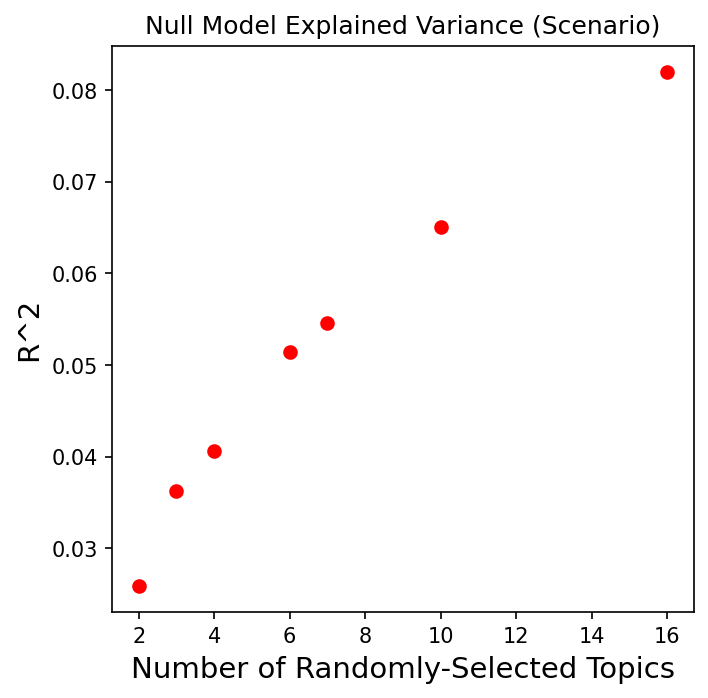

In [14]:
plt.figure(figsize=(5,5),dpi=150)
plt.plot(pd.Series(r2_dat['num_topics']), pd.Series(r2_dat['r2']),'ro')
plt.xlabel("Number of Randomly-Selected Topics", size=14)
plt.ylabel("R^2", size=14)
plt.title("Null Model Explained Variance (Scenario)")
#plt.legend(loc='upper right')


### example histogram of R2 values (scenario)

Crime-Type Bias R-Squared 95%-tile = 0.95    0.082019
Name: scenario_r2, dtype: float64


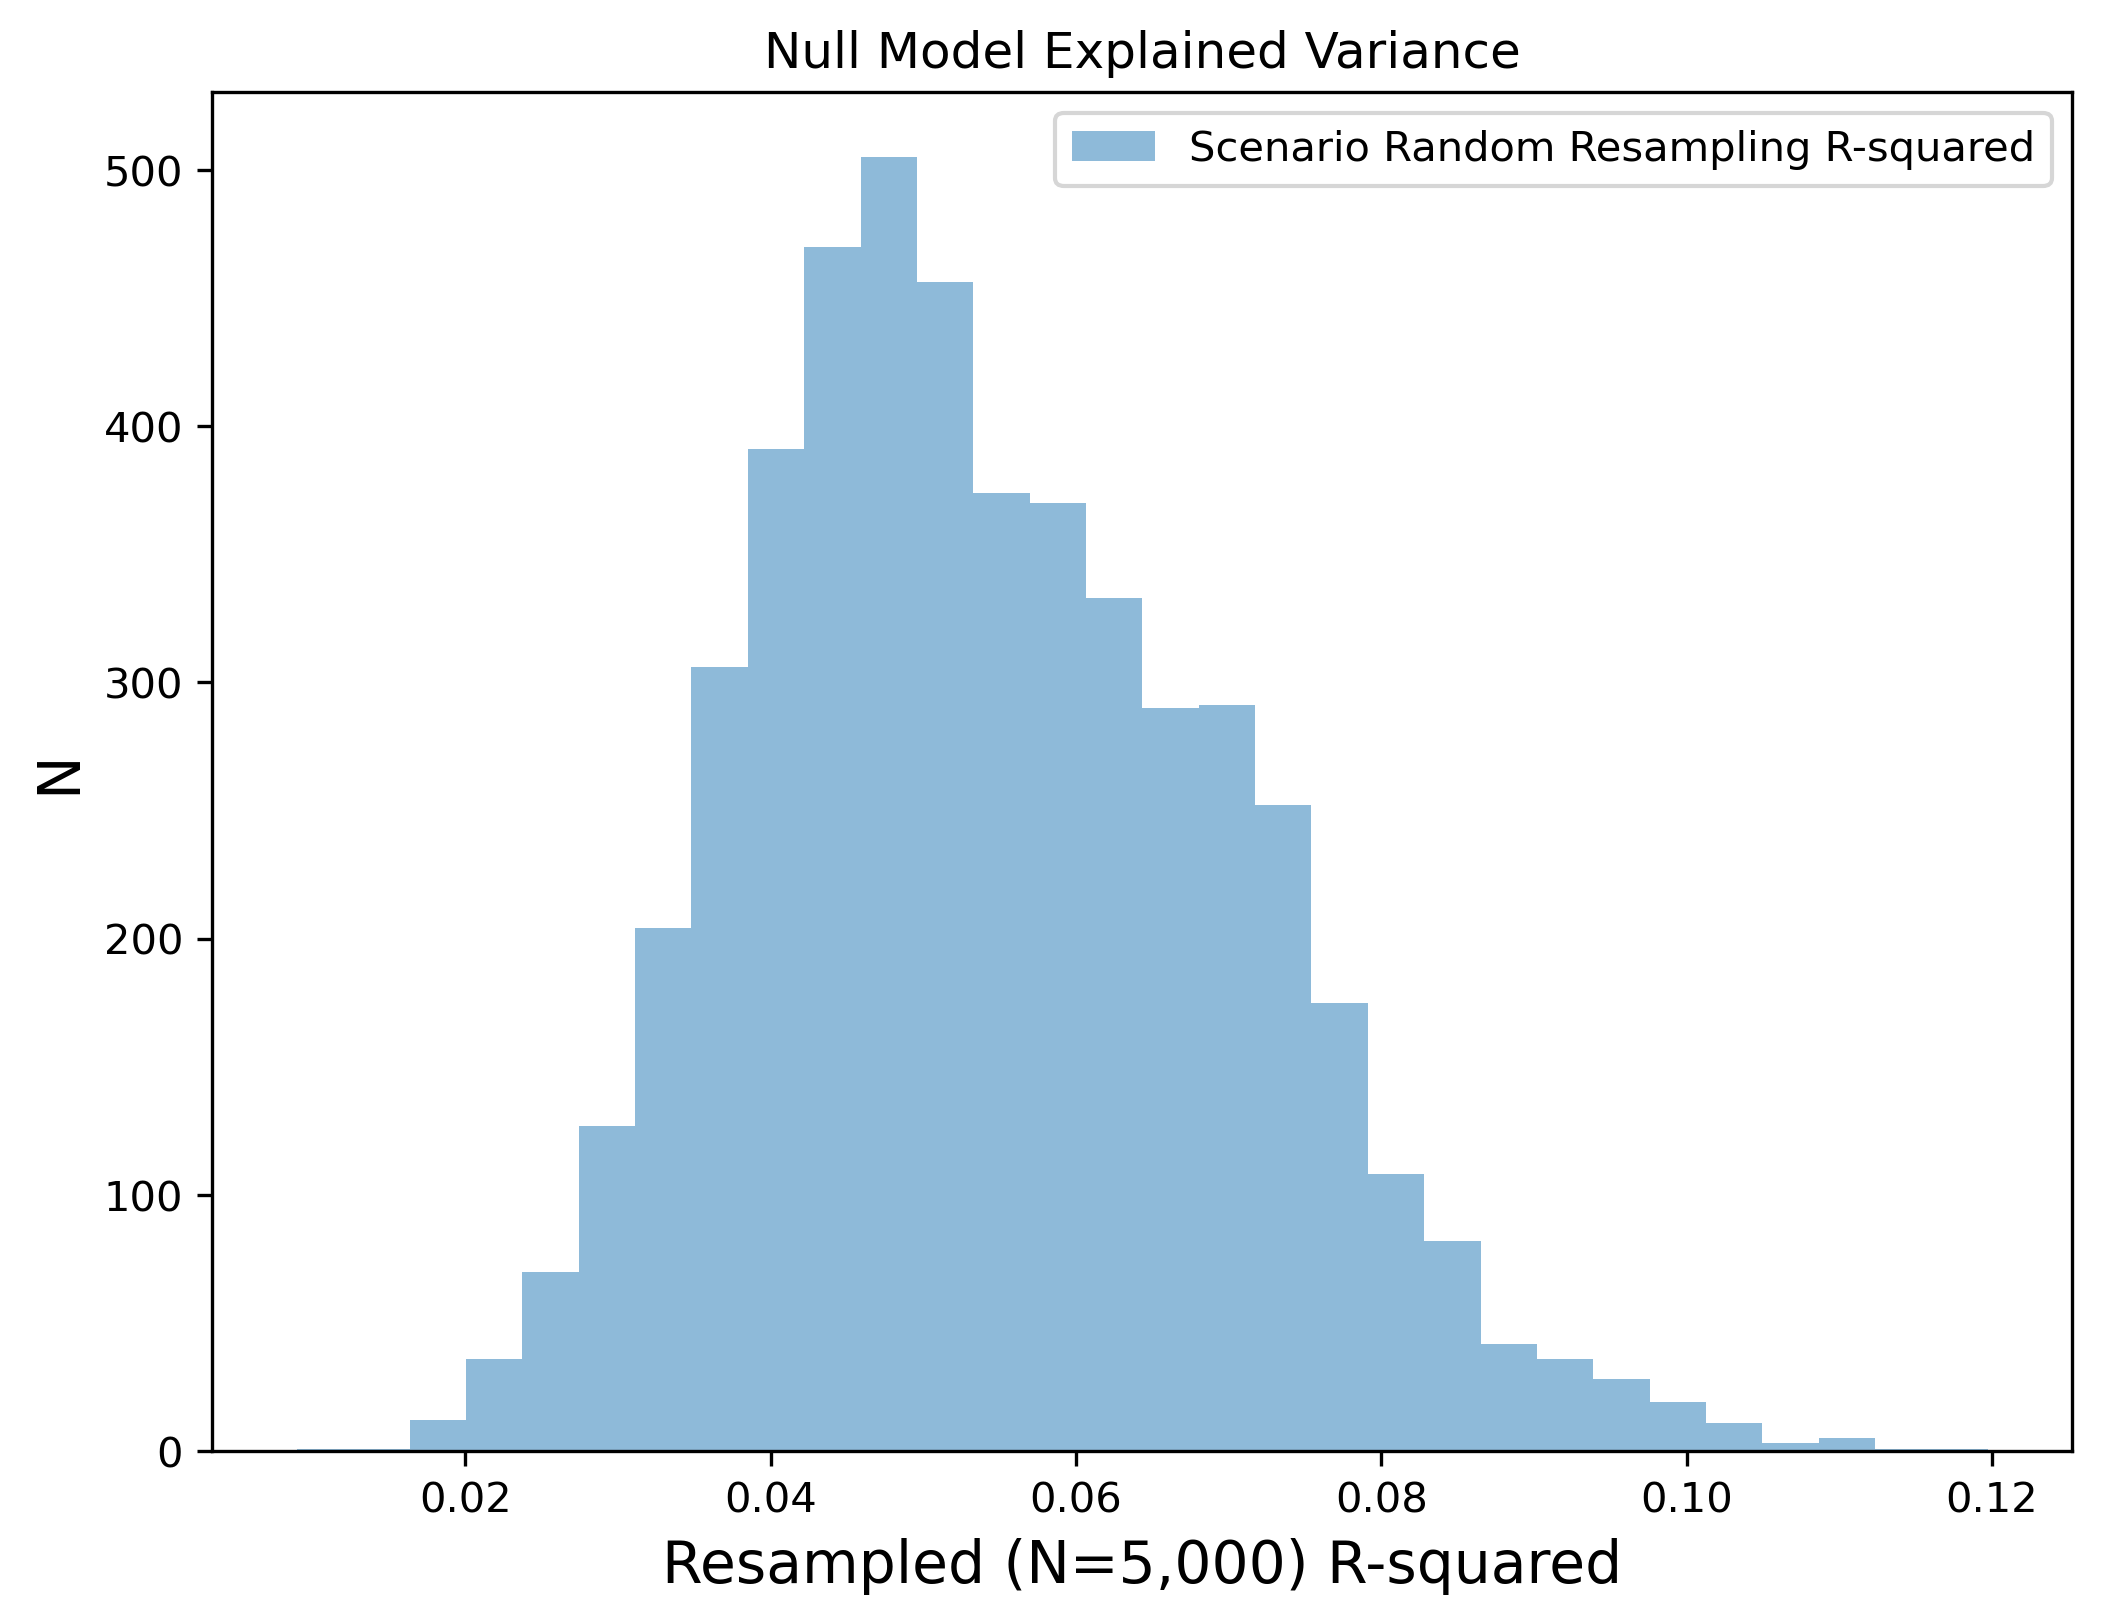

In [15]:
res_scenario_r2_mean = np.mean(pd.Series(res_r2['scenario_r2']))
res_scenario_r2_95_ci = np.percentile(pd.Series(res_r2['scenario_r2']), [2.5, 97.5])
print("Crime-Type Bias R-Squared 95%-tile = {}".format(res_scenario_r2_95_perc_rank))

plt.figure(figsize=(8,6),dpi=300)
plt.hist(pd.Series(res_r2['scenario_r2']), bins=30, alpha=0.5, label="Scenario Random Resampling R-squared")

plt.xlabel("Resampled (N=5,000) R-squared", size=14)
plt.ylabel("N", size=14)
plt.title("Null Model Explained Variance")
plt.legend(loc='upper right')

## Get percentiles (open from saved csv) - evidence

In [16]:
#simple percentile
k_vals = []
k_r2s = []
for k in ks:
    res_r2 = pd.read_csv('resampling/resampling_r2_values_evidence_unthresholded_k%s.csv'%k)
    r2 = pd.Series(res_r2['evidence_r2'])
    k_vals.append(k)
    arr = np.array([.95])
    res_evidence_r2_95_perc_rank = r2.quantile(arr)
    k_r2s.append(res_evidence_r2_95_perc_rank.iloc[0])
    print('R^2 for %s topics'%k)
    print(res_evidence_r2_95_perc_rank)

k_vals = pd.DataFrame(k_vals,columns=['num_topics'])
k_r2s = pd.DataFrame(k_r2s, columns=['r2'])
r2 = [k_vals, k_r2s]
r2_dat = pd.concat(r2, axis=1)
print(r2_dat)
r2_dat.to_csv('resampling/null_model_evidence_unthresholded_r2.csv',index=False)

R^2 for 2 topics
0.95    0.091331
Name: evidence_r2, dtype: float64
R^2 for 3 topics
0.95    0.118519
Name: evidence_r2, dtype: float64
R^2 for 4 topics
0.95    0.151284
Name: evidence_r2, dtype: float64
R^2 for 6 topics
0.95    0.183966
Name: evidence_r2, dtype: float64
R^2 for 7 topics
0.95    0.192309
Name: evidence_r2, dtype: float64
R^2 for 10 topics
0.95    0.222283
Name: evidence_r2, dtype: float64
R^2 for 16 topics
0.95    0.264082
Name: evidence_r2, dtype: float64
   num_topics        r2
0           2  0.091331
1           3  0.118519
2           4  0.151284
3           6  0.183966
4           7  0.192309
5          10  0.222283
6          16  0.264082


Text(0.5, 1.0, 'Null Model Explained Variance (Evidence)')

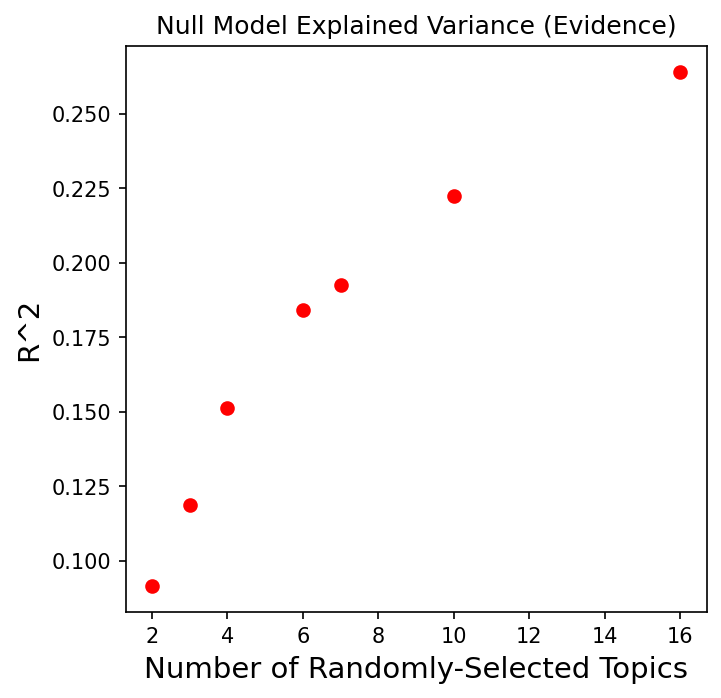

In [17]:
plt.figure(figsize=(5,5),dpi=150)
plt.plot(pd.Series(r2_dat['num_topics']), pd.Series(r2_dat['r2']),'ro')
plt.xlabel("Number of Randomly-Selected Topics", size=14)
plt.ylabel("R^2", size=14)
plt.title("Null Model Explained Variance (Evidence)")
#plt.legend(loc='upper right')


### example histogram of R2 values (evidence)

Evidence Accumulation R-Squared 95%-tile = 0.95    0.264082
Name: evidence_r2, dtype: float64


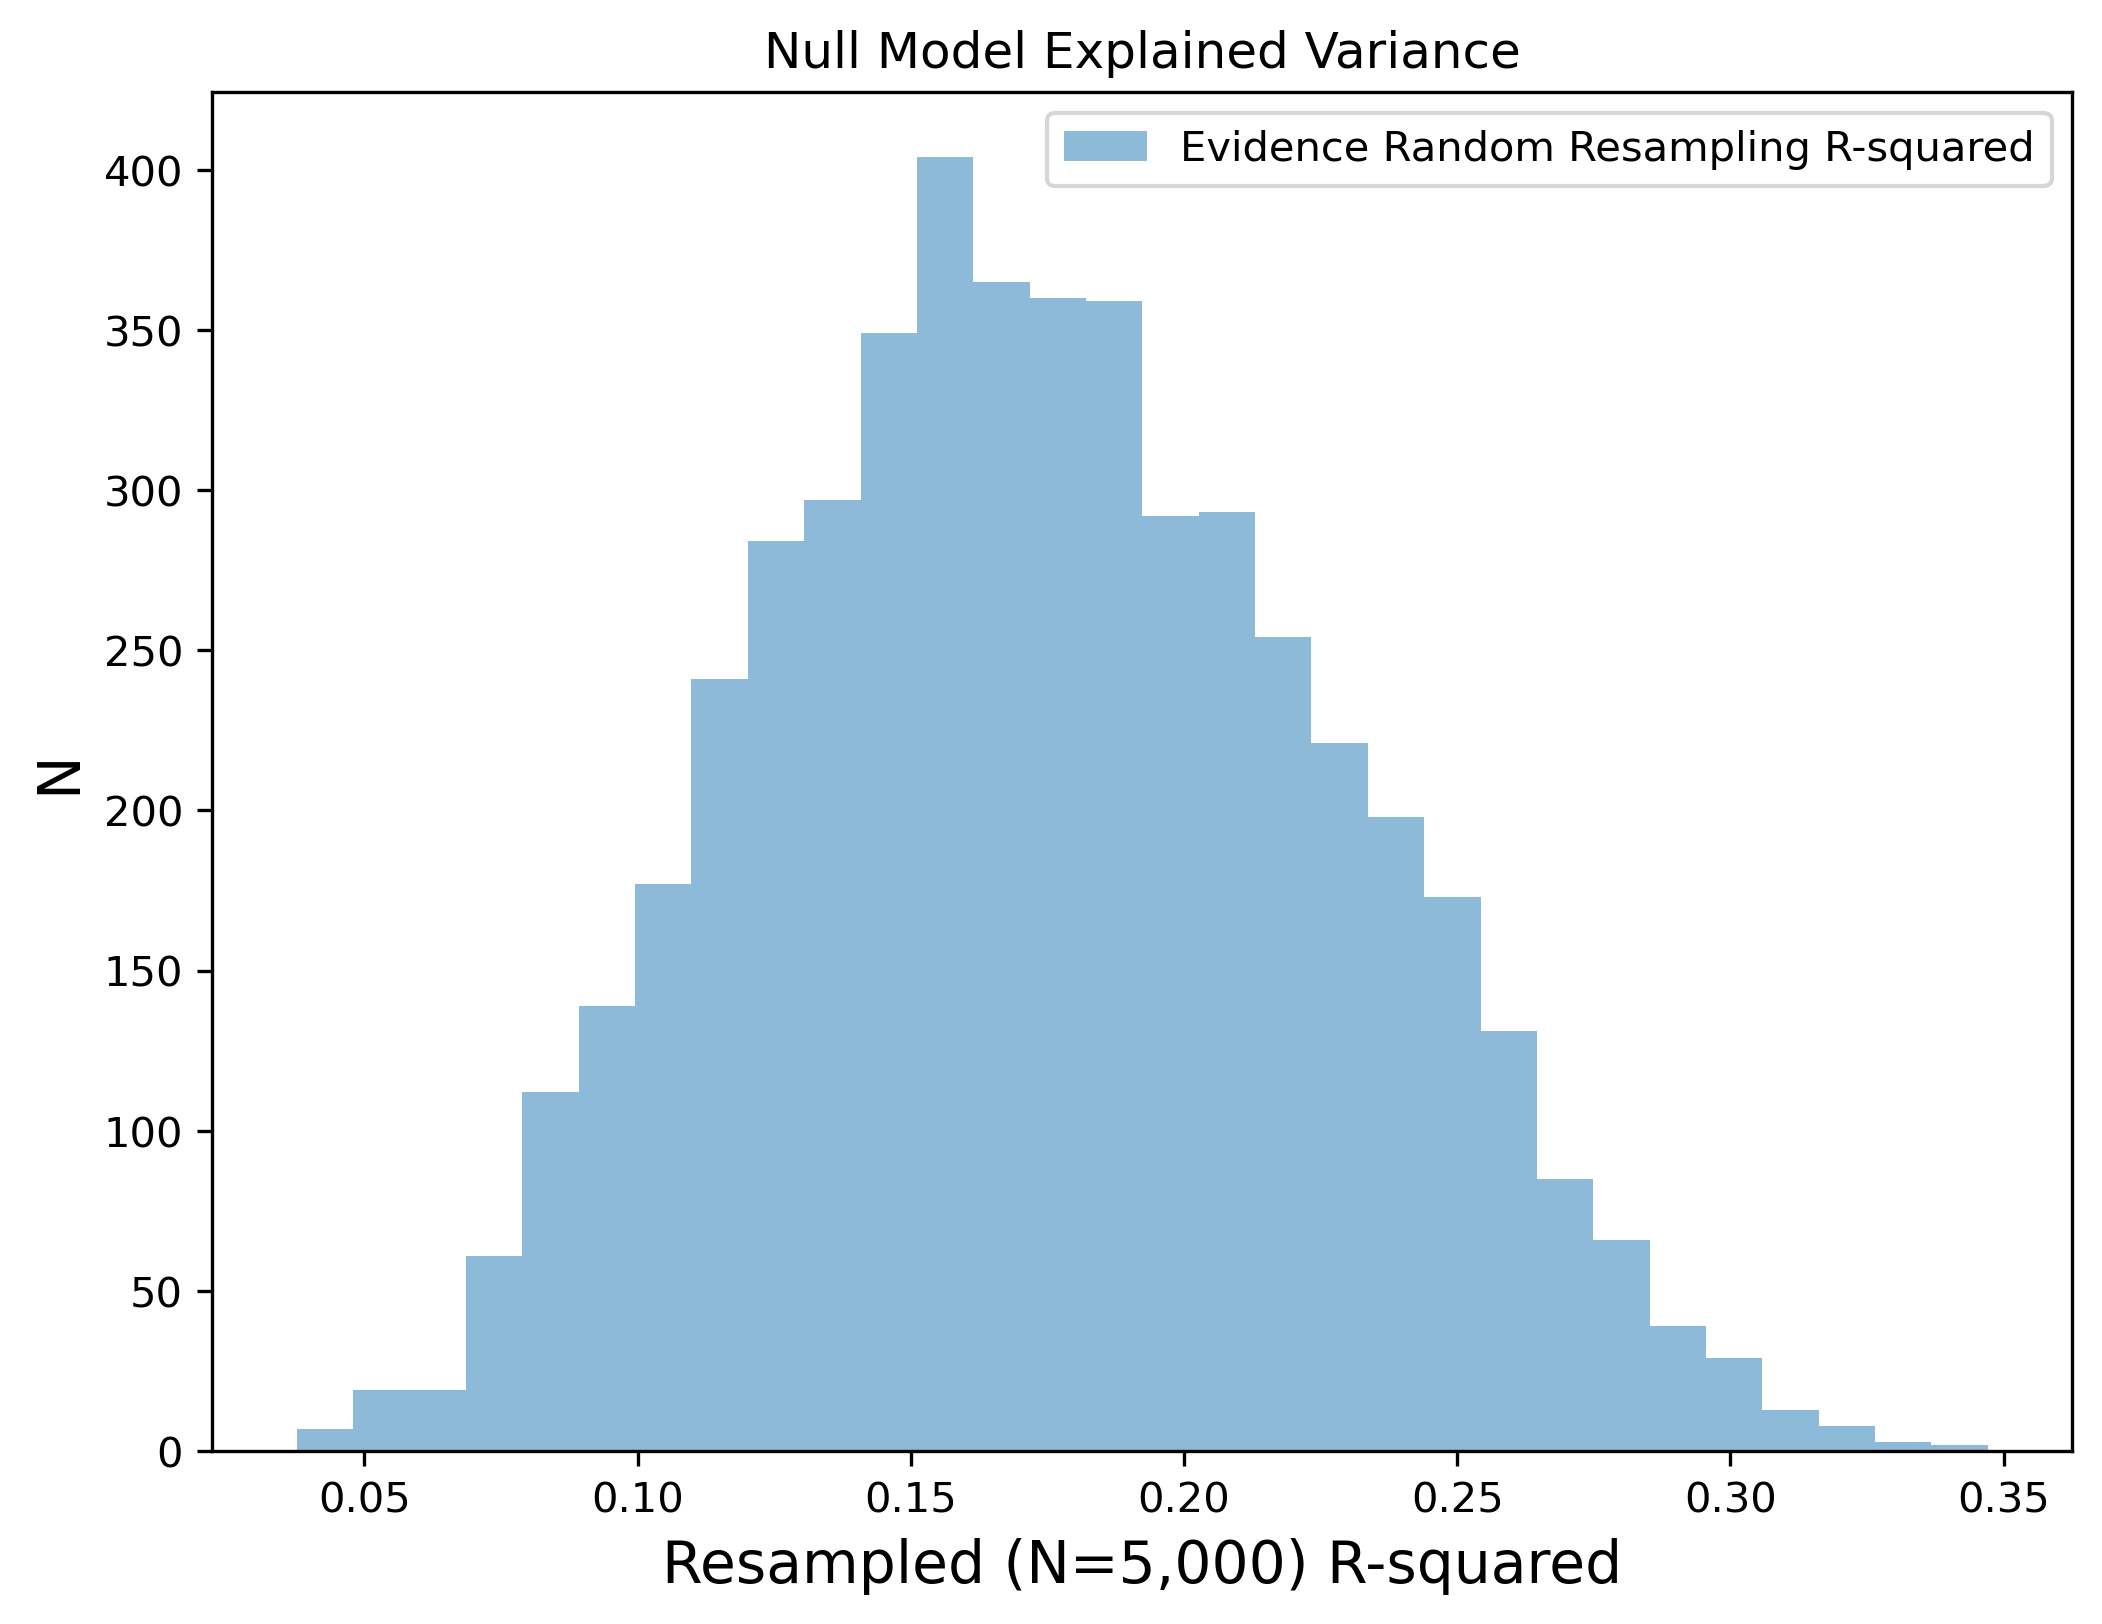

In [18]:
res_evidence_r2_mean = np.mean(pd.Series(res_r2['evidence_r2']))
res_evidence_r2_95_ci = np.percentile(pd.Series(res_r2['evidence_r2']), [2.5, 97.5])
print("Evidence Accumulation R-Squared 95%-tile = {}".format(res_evidence_r2_95_perc_rank))

plt.figure(figsize=(8,6),dpi=300)
plt.hist(pd.Series(res_r2['evidence_r2']), bins=30, alpha=0.5, label="Evidence Random Resampling R-squared")

plt.xlabel("Resampled (N=5,000) R-squared", size=14)
plt.ylabel("N", size=14)
plt.title("Null Model Explained Variance")
plt.legend(loc='upper right')

## Run multiple linear regression - Scenario

In [3]:
def spatial_regression(f,data):
    X = data.iloc[:, 4:]
    #standardized model for standardized regression coefficients
    X = X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
    Y = data[f]
    # with statsmodels
    X = sm.add_constant(X) # adding a constant
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)
    r2 = model.rsquared_adj
    bic = model.bic
    lme = bic*-0.5
    coef = model.params
    se = model.bse
    name = data.name
    fx = str(f)
    r2_vars = [f,name, r2]
    coef_vars = [coef, se]
    coef_dat = pd.DataFrame(coef_vars)
    
    
    return r2_vars, coef_dat


#string names for each model
extra_evid_data.name = 'extra_evidentiary'
evid_data.name = 'evidentiary'
narrative_data.name = 'narrative'
m1_data.name = 'utility'
m2_data.name = 'affect'
m3_data.name = 'moral_judgment'
m4_data.name = 'exp_cult_recall_narrative'
m5_data.name = 'reading_narrative'
m6_data.name = 'wm_narrative'
m1a_data.name = 'utility_probability'
m1b_data.name = 'utility_value'
m3a_data.name = 'moral_judgment_social'
m3b_data.name = 'moral_judgment_mj'
m4a_data.name = 'exp_cult_recall_narrative_cult_id_bias'
m4b_data.name = 'exp_cult_recall_narrative_recall'

#list of effects to pull
fmri = ['scenario', 'evidence', 'case_strength', 'punishment']

# list of models
models = [extra_evid_data, evid_data, narrative_data, m1_data,
       m2_data, m3_data, m4_data, m5_data, m6_data, m1a_data,
       m1b_data, m3a_data, m3b_data, m4a_data, m4b_data]

outputs = []
r2_dats = []
coef_dats_list = []
for f in fmri:
    for m in models:
        output = spatial_regression(f,m)
        #r-squared data (appending the r2_vars)
        r2_dats.append(output[0])
        r2_data = pd.DataFrame(r2_dats)
        #coefficients data (appending the coef_vars)
        coef_dat = output[1].T
        coef_dat.reset_index(level=coef_dat.index.names, inplace=True)
        coef_dat.columns =['coef_name', 'coef', 'se'] 
        coef_dat['model'] = str(m.name)
        coef_dat['effect'] = str(f)
        coef_dats = pd.DataFrame(coef_dat)
        coef_dats_list.append(coef_dats)
coef_data = pd.concat(coef_dats_list)

#save r-squared values
r2_data.columns =['event', 'model', 'r2']
r2_data.to_csv('decoding_output/model_r2_unthresholded.csv')

#save coefficients
coef_data.to_csv('decoding_output/model_coefficients_unthresholded.csv')

                            OLS Regression Results                            
Dep. Variable:               scenario   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2077.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:22   Log-Likelihood:            -3.3867e+05
No. Observations:              228483   AIC:                         6.773e+05
Df Residuals:                  228475   BIC:                         6.774e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.002     74.342      0.0

                            OLS Regression Results                            
Dep. Variable:               scenario   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1552.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:23   Log-Likelihood:            -3.4341e+05
No. Observations:              228483   AIC:                         6.868e+05
Df Residuals:                  228479   BIC:                         6.869e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.002     72.815      0.0

                            OLS Regression Results                            
Dep. Variable:               scenario   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     367.6
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          3.51e-238
Time:                        15:50:24   Log-Likelihood:            -3.4517e+05
No. Observations:              228483   AIC:                         6.903e+05
Df Residuals:                  228479   BIC:                         6.904e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.002     72.258      0.0

                            OLS Regression Results                            
Dep. Variable:               evidence   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     588.8
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:25   Log-Likelihood:            -4.5105e+05
No. Observations:              228483   AIC:                         9.021e+05
Df Residuals:                  228475   BIC:                         9.022e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2312      0.004     63.434      0.0

                            OLS Regression Results                            
Dep. Variable:               evidence   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     323.0
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          2.47e-209
Time:                        15:50:26   Log-Likelihood:            -4.5261e+05
No. Observations:              228483   AIC:                         9.052e+05
Df Residuals:                  228479   BIC:                         9.053e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2312      0.004     63.003      0.0

                            OLS Regression Results                            
Dep. Variable:               evidence   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:27   Log-Likelihood:            -4.4181e+05
No. Observations:              228483   AIC:                         8.836e+05
Df Residuals:                  228480   BIC:                         8.837e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2312      0.004     66.051      0.0

                            OLS Regression Results                            
Dep. Variable:               evidence   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     7373.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:28   Log-Likelihood:            -4.4595e+05
No. Observations:              228483   AIC:                         8.919e+05
Df Residuals:                  228480   BIC:                         8.919e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2312      0.004     64.867      0.0

                            OLS Regression Results                            
Dep. Variable:          case_strength   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     137.0
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           1.06e-88
Time:                        15:50:29   Log-Likelihood:            -2.6666e+05
No. Observations:              228483   AIC:                         5.333e+05
Df Residuals:                  228479   BIC:                         5.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1816      0.002   -111.665      0.0

                            OLS Regression Results                            
Dep. Variable:          case_strength   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     733.7
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          2.31e-318
Time:                        15:50:30   Log-Likelihood:            -2.6614e+05
No. Observations:              228483   AIC:                         5.323e+05
Df Residuals:                  228480   BIC:                         5.323e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1816      0.002   -111.923      0.0

                            OLS Regression Results                            
Dep. Variable:          case_strength   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     627.9
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          1.09e-272
Time:                        15:50:30   Log-Likelihood:            -2.6624e+05
No. Observations:              228483   AIC:                         5.325e+05
Df Residuals:                  228480   BIC:                         5.325e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1816      0.002   -111.871      0.0

                            OLS Regression Results                            
Dep. Variable:             punishment   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1417.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:32   Log-Likelihood:            -3.2544e+05
No. Observations:              228483   AIC:                         6.509e+05
Df Residuals:                  228472   BIC:                         6.510e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1996      0.002    570.300      0.0

                            OLS Regression Results                            
Dep. Variable:             punishment   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     996.2
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:50:32   Log-Likelihood:            -3.3034e+05
No. Observations:              228483   AIC:                         6.607e+05
Df Residuals:                  228478   BIC:                         6.607e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1996      0.002    558.209      0.0

                            OLS Regression Results                            
Dep. Variable:             punishment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     143.0
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           8.84e-63
Time:                        15:50:33   Log-Likelihood:            -3.3218e+05
No. Observations:              228483   AIC:                         6.644e+05
Df Residuals:                  228480   BIC:                         6.644e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1996      0.002    553.752      0.0

In [165]:
#print(r2_data)
#print(coef_data)

In [8]:
#scenario
#get p-val/ranks
scenario_res_r2 = pd.read_csv('resampling/null_model_scenario_unthresholded_r2.csv')
r2_data = pd.read_csv('decoding_output/model_r2_unthresholded.csv')
r2_data = r2_data[r2_data['event']=='scenario']
r2_data['model_name'] = r2_data['model']

#link model names to r2
model_df = pd.DataFrame(columns=['num_topics', 'model_name'],
                        data=[[16,'evidentiary'],[10,'narrative'],
                              [7,'extra_evidentiary'],[6,'utility'],[4,'moral_judgment'],[4,'exp_cult_recall_narrative'],
                              [4,'reading_narrative'],[3,'affect'],[3,'utility_probability'],[3,'utility_value'],
                              [2,'moral_judgment_social'],[2,'moral_judgment_mj'],
                              [2,'exp_cult_recall_narrative_cult_id_bias'],[2,'exp_cult_recall_narrative_recall'],
                              [2,'wm_narrative']])

model_list = model_df['model_name'].tolist()
scenario_res_r2_w_model = pd.merge(scenario_res_r2, model_df, on="num_topics")
scenario_res_r2_w_model_w_actual = pd.merge(scenario_res_r2_w_model, r2_data, on="model_name")
#print(scenario_res_r2_w_model_w_actual)


modelnames = ['evidentiary','narrative','extra_evidentiary','utility',
             'moral_judgment','exp_cult_recall_narrative','reading_narrative','affect',
              'utility_probability','utility_value','moral_judgment_social','moral_judgment_mj',
              'exp_cult_recall_narrative_cult_id_bias','exp_cult_recall_narrative_recall','wm_narrative']
ks = [2,3,4,6,7,10,16]
#k_vals = []
#k_r2s = []
for k in ks:
    res_r2 = pd.read_csv('resampling/resampling_r2_values_scenario_unthresholded_k%s.csv'%k)
    res_r2 = res_r2.sort_values(by='scenario_r2', ascending=True)
    for m in modelnames:
        threshold_data = scenario_res_r2_w_model_w_actual[scenario_res_r2_w_model_w_actual['model_name'] == m]
        res = res_r2[res_r2['scenario_r2'] >= threshold_data['r2_y'].iloc[0]]
        if k == threshold_data['num_topics'].iloc[0]:
            print('Model Size: '+str(k))
            print('Model Name: '+str(m))
            print('# of Null Models w/higher R^2: ' +str(len(res)))
            print('...............')


Model Size: 2
Model Name: moral_judgment_social
# of Null Models w/higher R^2: 73
...............
Model Size: 2
Model Name: moral_judgment_mj
# of Null Models w/higher R^2: 3380
...............
Model Size: 2
Model Name: exp_cult_recall_narrative_cult_id_bias
# of Null Models w/higher R^2: 595
...............
Model Size: 2
Model Name: exp_cult_recall_narrative_recall
# of Null Models w/higher R^2: 2278
...............
Model Size: 2
Model Name: wm_narrative
# of Null Models w/higher R^2: 4995
...............
Model Size: 3
Model Name: affect
# of Null Models w/higher R^2: 1029
...............
Model Size: 3
Model Name: utility_probability
# of Null Models w/higher R^2: 4015
...............
Model Size: 3
Model Name: utility_value
# of Null Models w/higher R^2: 3574
...............
Model Size: 4
Model Name: moral_judgment
# of Null Models w/higher R^2: 263
...............
Model Size: 4
Model Name: exp_cult_recall_narrative
# of Null Models w/higher R^2: 1176
...............
Model Size: 4
Mod

In [7]:
#evidence
#get p-val/ranks
evidence_res_r2 = pd.read_csv('resampling/null_model_evidence_unthresholded_r2.csv')
r2_data = pd.read_csv('decoding_output/model_r2_unthresholded.csv')
r2_data = r2_data[r2_data['event']=='evidence']
r2_data['model_name'] = r2_data['model']

#link model names to r2
model_df = pd.DataFrame(columns=['num_topics', 'model_name'],
                        data=[[16,'evidentiary'],[10,'narrative'],
                              [7,'extra_evidentiary'],[6,'utility'],[4,'moral_judgment'],[4,'exp_cult_recall_narrative'],
                              [4,'reading_narrative'],[3,'affect'],[3,'utility_probability'],[3,'utility_value'],
                              [2,'moral_judgment_social'],[2,'moral_judgment_mj'],
                              [2,'exp_cult_recall_narrative_cult_id_bias'],[2,'exp_cult_recall_narrative_recall'],
                              [2,'wm_narrative']])

model_list = model_df['model_name'].tolist()
evidence_res_r2_w_model = pd.merge(evidence_res_r2, model_df, on="num_topics")
evidence_res_r2_w_model_w_actual = pd.merge(evidence_res_r2_w_model, r2_data, on="model_name")
#print(evidence_res_r2_w_model_w_actual)


modelnames = ['evidentiary','narrative','extra_evidentiary','utility',
             'moral_judgment','exp_cult_recall_narrative','reading_narrative','affect',
              'utility_probability','utility_value','moral_judgment_social','moral_judgment_mj',
              'exp_cult_recall_narrative_cult_id_bias','exp_cult_recall_narrative_recall','wm_narrative']
ks = [2,3,4,6,7,10,16]
#k_vals = []
#k_r2s = []
for k in ks:
    res_r2 = pd.read_csv('resampling/resampling_r2_values_evidence_unthresholded_k%s.csv'%k)
    res_r2 = res_r2.sort_values(by='evidence_r2', ascending=True)
    for m in modelnames:
        threshold_data = evidence_res_r2_w_model_w_actual[evidence_res_r2_w_model_w_actual['model_name'] == m]
        res = res_r2[res_r2['evidence_r2'] >= threshold_data['r2_y'].iloc[0]]
        if k == threshold_data['num_topics'].iloc[0]:
            print('Model Size: '+str(k))
            print('Model Name: '+str(m))
            print('# of Null Models w/higher R^2: ' +str(len(res)))
            print('...............')


Model Size: 2
Model Name: moral_judgment_social
# of Null Models w/higher R^2: 3805
...............
Model Size: 2
Model Name: moral_judgment_mj
# of Null Models w/higher R^2: 3573
...............
Model Size: 2
Model Name: exp_cult_recall_narrative_cult_id_bias
# of Null Models w/higher R^2: 2335
...............
Model Size: 2
Model Name: exp_cult_recall_narrative_recall
# of Null Models w/higher R^2: 825
...............
Model Size: 2
Model Name: wm_narrative
# of Null Models w/higher R^2: 218
...............
Model Size: 3
Model Name: affect
# of Null Models w/higher R^2: 4773
...............
Model Size: 3
Model Name: utility_probability
# of Null Models w/higher R^2: 277
...............
Model Size: 3
Model Name: utility_value
# of Null Models w/higher R^2: 2323
...............
Model Size: 4
Model Name: moral_judgment
# of Null Models w/higher R^2: 4558
...............
Model Size: 4
Model Name: exp_cult_recall_narrative
# of Null Models w/higher R^2: 1685
...............
Model Size: 4
Mo